In [46]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))
from glob import glob
import h5py
from tqdm import tqdm

In [37]:
import sys
sys.path.append('../keras_network/')
sys.path.append('../data_processing/')
from data_generator import DataGenerator

In [3]:
from losses import metrics
from keras.utils.generic_utils import get_custom_objects
metrics_dict = dict([(f.__name__, f) for f in metrics])
get_custom_objects().update(metrics_dict)

In [4]:
from preprocess_aqua import L_V, C_P, conversion_dict

In [5]:
model_path = '/export/home/srasp/repositories/CBRAIN-Keras-Diagnostics/keras_network/models/000_test.h5.h5'

In [6]:
data_dir = '/beegfs/DATA/pritchard/srasp/Aquaplanet_enhance05/'

In [7]:
pre_dir = '/beegfs/DATA/pritchard/srasp/preprocessed_data/'

In [21]:
range_dict = {
    'SPDT' : [-5e-4, 5e-4],
    'SPDQ' : [-5e-7, 5e-7],
    'QRL' : [-2e-4, 2e-4],
    'QRS' : [-1.2e-4, 1.2e-4]
}

In [53]:
class ModelDiagnostics(object):
    """
    TODO:
    - colorbar
    - x-y labels
    """
    def __init__(self, model_path, keras_features_fn, keras_targets_fn, keras_norm_fn,
                 nlat=64, nlon=128):
        """
        keras_features [sample, input_z]
        keras_targets [sample, output_z]
        """
        self.model_path = model_path
        self.model = self.load_model()
        self.keras_features_fn = keras_features_fn
        self.keras_targets_fn = keras_targets_fn
        self.keras_norm_fn = keras_norm_fn
        self.keras_features = h5py.File(keras_features_fn, 'r')
        self.keras_targets = h5py.File(keras_targets_fn, 'r')
        self.keras_norm = h5py.File(keras_norm_fn, 'r')
        self.nlat = nlat; self.nlon = nlon
        self.ngeo = nlat * nlon
        
    def load_model(self):
        # For keras model
        return keras.models.load_model(self.model_path)
    #def get_files(self):
    #    return sorted(glob(self.data_dir + self.aqua_pref + '*'))
    
    def plot_lat_lev_slice(self, var, itime, ilon):
        # Get actual values
        #true = xr.open_dataset(
        #    self.aqua_files[idate], decode_times=False)[var].isel(time=itime, lon=ilon)
        
        # Get predictions and true values. THIS WILL BE DIFFERENT FOR TF
        preds, true = self.get_preds_and_truth(var, itime)
        preds = preds[:, ilon, :]; true = true[:, ilon, :]
        self.plot_slice(preds.T, true.T, var)
        
    def plot_lat_lon_slice(self, var, itime, ilev):
        # Get predictions and true values. THIS WILL BE DIFFERENT FOR TF
        preds, true = self.get_preds_and_truth(var, itime)
        preds = preds[:, :, ilev]; true = true[:, :, ilev]
        self.plot_slice(preds, true, var)
        
    def plot_slice(self, p, t, var):
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        axes[0].imshow(p, vmin=range_dict[var][0], vmax=range_dict[var][1], cmap='bwr')
        axes[1].imshow(t, vmin=range_dict[var][0], vmax=range_dict[var][1], cmap='bwr')
        axes[0].set_title('CBRAIN Predictions')
        axes[1].set_title('SP-CAM Truth')
        plt.show()
        
    def get_preds_and_truth(self, var, itime):
        f = self.keras_features['features'][itime*self.ngeo:(itime+1)*self.ngeo]
        p = self.model.predict_on_batch(f)
        t = self.keras_targets['targets'][itime*self.ngeo:(itime+1)*self.ngeo]
        return self.reshape_output(p, var), self.reshape_output(t, var)
    
    def reshape_output(self, x, var, unscale=True):
        """
        Assumes [sample, z] for one time step
        """
        x = x.reshape(self.nlat, self.nlon, x.shape[-1]) # [lat, lon, z]
        var_idxs = [i for i, s in enumerate(list(self.keras_targets['target_names'][:])) 
                    if var in s]
        x = x[:, :, var_idxs]
        # Unscale
        if unscale: x /= conversion_dict[var]
        return x
    
    def compute_stats(self):
        """
        Compute statistics over entire dataset [lat, lon, lev].
        bias = mean(preds) - mean(true)
        mse = sse(preds, true) / n_samples
        rel_mse = mse / std(true)
        std_error = std(preds) - std(true)
        """
        # Get data generator without shuffling!
        gen_obj = DataGenerator(
            '/',
            self.keras_features_fn,
            self.keras_targets_fn,
            shuffle=False,
            batch_size=self.ngeo,   # time step sized batches
            verbose=True,
        )
        gen = gen_obj.return_generator()
        psum = np.zeros((self.ngeo, gen_obj.target_shape))
        tsum = np.copy(psum); sse = np.copy(psum)
        #for t in tqdm(range(gen_obj.n_batches)):
        for t in tqdm(range(25)):
            # Load features and targets
            f, t = next(gen)
            # Get predictions
            p = self.model.predict_on_batch(f)   # [ngeo samples, z]
            # Compute statistics
            psum += p; tsum += t
            sse += (t - p) ** 2
        
        # Compute average statistics
        self.bias = (psum - tsum) / gen_obj.n_batches
        self.mse = sse / gen_obj.n_batches
        

In [54]:
diag = ModelDiagnostics(
    model_path, 
    pre_dir + 'pure_crm_essentials_valid_month02_features.nc',
    pre_dir + 'pure_crm_essentials_valid_month02_targets.nc',
    pre_dir + 'pure_crm_essentials_train_month01_norm.nc'
)

In [56]:
diag.compute_stats()


  0%|          | 0/25 [00:00<?, ?it/s]

Generator will have 11001856 samples in 1343 batches
Features have shape 152; targets have shape 120



100%|██████████| 25/25 [00:01<00:00, 19.04it/s]


In [62]:
a = diag.reshape_output(diag.mse, 'SPDT')

In [63]:
a.shape

(64, 128, 30)

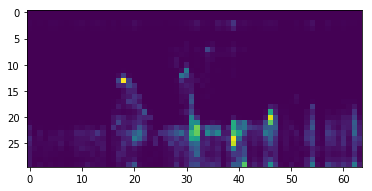

In [64]:
plt.imshow(a[:, 0, :].T)